In [ ]:
import pyodbc 
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

In [67]:
def wrangle(db):
    # Connect to database
    conn = pyodbc.connect(db)
    # Construct query
    query = """
    select 
    h.* ,s.*,i.vdcmun_id,d.damage_grade
    from household_demographics$ as h
    join id_map$ as i on i.household_id=h.household_id
    join building_structure$ as s on i.building_id=s.building_id
    join building_damage$ as d on i.building_id=d.building_id
    where district_id=4
    """
    # Read query results into DataFrame
    df = pd.read_sql(query,conn,index_col="household_id")
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    # Add high-cardinality / redundant column
    drop_cols.append("building_id")
    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    # Drop old target
    drop_cols.append("damage_grade")
    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")
    
    top_10=df["caste_household"].value_counts().head(10).index
    df["caste_household"]=df["caste_household"].apply(
        lambda c: c if c in top_10 else "Other"
    )
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)
    return df


In [68]:
# Prepare Data
# Import
df=wrangle('Driver={SQL Server};'
        'Server=DESKTOP-C6O0T9S;'
        'Database=PortfolioProject;'
        'Trusted_Connection=yes;')
df.head()

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12512\1881495802.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn,index_col="household_id")


,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,vdcmun_id,severe_damage
household_id,,,,,,,,,,,,,,,,,,,,
16758101.0,Male,53.0,Sarki,Class 3,Rs. 10 thousand,6.0,0.0,17.0,420.0,21.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,"Stone, mud mortar",30.0,1
16760601.0,Female,40.0,Brahman-Hill,Class 2,Rs. 10 thousand,4.0,1.0,29.0,165.0,14.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,"Stone, mud mortar",30.0,1
16758201.0,Female,37.0,Sarki,Non-formal education,Rs. 10-20 thousand,7.0,1.0,45.0,230.0,14.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",30.0,1
16758301.0,Male,55.0,Sarki,Non-formal education,Rs. 10 thousand,3.0,0.0,28.0,180.0,14.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",30.0,1
16758401.0,Male,42.0,Sarki,Class 5,Rs. 10 thousand,6.0,1.0,40.0,270.0,14.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",30.0,1


In [69]:
# high- and low-cardinality categorical features
df.select_dtypes("object").nunique()

gender_household_head              2
caste_household                   11
education_level_household_head    19
income_level_household             5
land_surface_condition             3
foundation_type                    5
roof_type                          3
ground_floor_type                  5
other_floor_type                   4
position                           4
plan_configuration                10
superstructure                    11
dtype: int64

In [70]:
# the "caste_household" contains only the 10 largest caste groups
df["caste_household"].nunique()
top_10=df["caste_household"].value_counts().head(10).index
df["caste_household"].apply(lambda c: c if c in top_10 else "Other" )

household_id
16758101.0           Sarki
16760601.0    Brahman-Hill
16758201.0           Sarki
16758301.0           Sarki
16758401.0           Sarki
                  ...     
19769801.0          Tamang
19776101.0          Gurung
19783001.0          Tamang
19783003.0          Tamang
22441401.0          Gurung
Name: caste_household, Length: 75883, dtype: object

In [71]:
# Split
target = "severe_damage"
X = df.drop(columns=[target,"vdcmun_id"])
y = df[target]

In [72]:
# training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [73]:
# Build Model
# Baseline
# the baseline accuracy
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.63


In [74]:
# Iterate
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=3000)
)
model_lr.fit(X_train,y_train)
check_is_fitted(model_lr)

In [75]:
# the training and test accuracy scores
acc_train = model_lr.score(X_train,y_train)
acc_test = model_lr.score(X_test,y_test)
print("LR Training Accuracy:", acc_train)
print("LR Validation Accuracy:", acc_test)

LR Training Accuracy: 0.720801897670741
LR Validation Accuracy: 0.7133820913223957


In [76]:
# the feature names and importances
features = model_lr.named_steps["onehotencoder"].get_feature_names()
importances = model_lr.named_steps["logisticregression"].coef_[0]
feat_imp = pd.Series(np.exp(importances),index =features).sort_values()
feat_imp.head()

C:\Users\PanDa\anaconda3\lib\site-packages\category_encoders\utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


superstructure_Brick, cement mortar    0.304569
foundation_type_RC                     0.348021
roof_type_RCC/RB/RBC                   0.396507
caste_household_Kumal                  0.520868
ground_floor_type_RC                   0.523444
dtype: float64

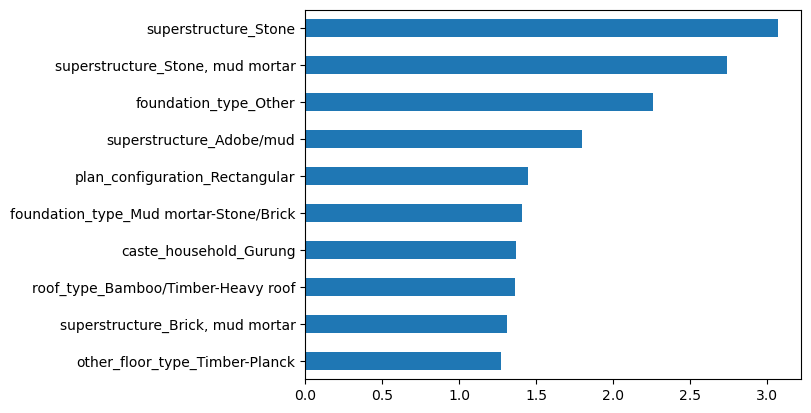

In [78]:
# horizontal bar chart with the ten largest coefficients from feat_imp
feat_imp.tail(10).plot(kind="barh");

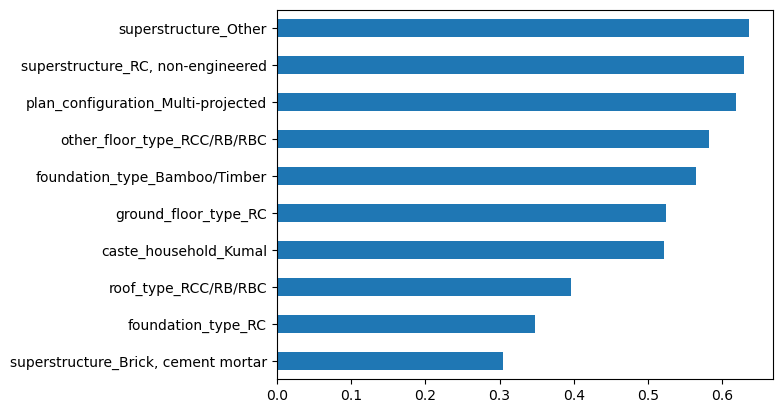

In [80]:
# horizontal bar chart with the ten smallest coefficients from feat_imp
feat_imp.head(10).plot(kind="barh");

In [81]:
# Which municipalities saw the highest proportion of severely damaged buildings?
damage_by_vdcmun = (
df.groupby("vdcmun_id")['severe_damage'].mean().sort_values(ascending=False).to_frame()
)
damage_by_vdcmun

,severe_damage
vdcmun_id,
31.0,0.930199
32.0,0.851117
35.0,0.827145
30.0,0.824201
33.0,0.782464
34.0,0.666979
39.0,0.572344
40.0,0.512444
38.0,0.506425


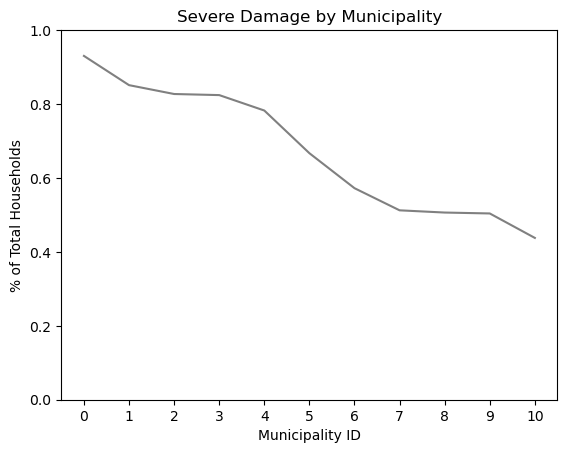

In [82]:
# line plot of damage_by_vdcmun.
plt.plot(damage_by_vdcmun.values,color="grey")
plt.xticks(range(len(damage_by_vdcmun)),label =damage_by_vdcmun.index)
plt.yticks(np.arange(0.0,1.1,.2))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");

In [83]:
# the proportion of Gurung households
damage_by_vdcmun["Gurung"] = (
df[df["caste_household"]=='Gurung'].groupby('vdcmun_id')["severe_damage"].count()
    /df.groupby('vdcmun_id')["severe_damage"].count()
)

# the proportion of Kumal households
damage_by_vdcmun["Kumal"] = (
df[df["caste_household"]=='Kumal'].groupby('vdcmun_id')["severe_damage"].count()
    /df.groupby('vdcmun_id')["severe_damage"].count()
).fillna(0)
damage_by_vdcmun

,severe_damage,Gurung,Kumal
vdcmun_id,,,
31.0,0.930199,0.326937,0.000000
32.0,0.851117,0.387849,0.000000
35.0,0.827145,0.826889,0.000000
30.0,0.824201,0.338152,0.000000
33.0,0.782464,0.011943,0.029478
34.0,0.666979,0.385084,0.000000
39.0,0.572344,0.097971,0.000267
40.0,0.512444,0.246727,0.036973
38.0,0.506425,0.049023,0.100686


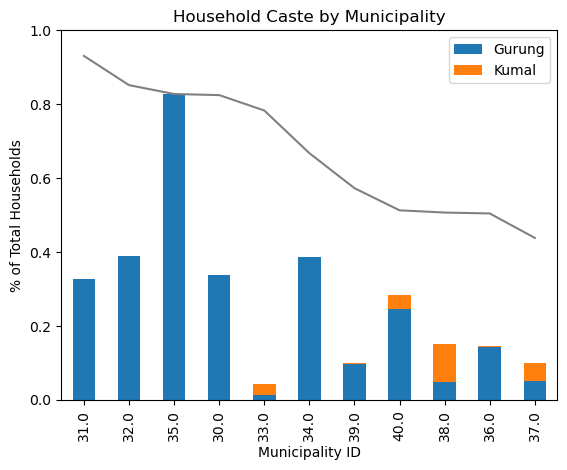

In [84]:
# line plot of severely damaged households
damage_by_vdcmun.drop(columns ='severe_damage').plot(kind="bar",stacked=True)
plt.plot(damage_by_vdcmun['severe_damage'].values,color="grey")
plt.xticks(range(len(damage_by_vdcmun)),label =damage_by_vdcmun.index)
plt.yticks(np.arange(0.0,1.1,.2))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Household Caste by Municipality")
plt.legend();